# LLE Case 1 Python Notebook

This notebook mirrors the original `Case_1_markdown.Rmd` analysis using Python only.
Synthetic longitudinal data are generated, transformed, and modeled with the same logic
that powered the R workflow so the entire case study can be executed from a single file.

### Data-generation recap

The Case 1 signals are designed to mimic noisy, partially correlated sensors:

1. Each variable is a composite of randomized sine waves, so every channel drifts over time.
2. All variables remain range bound to resemble physical measurements.
3. Only seven of forty channels drive the target; their time-shifted threshold crossings must
   all be satisfied to trigger an event.
4. Every example flattens eleven time steps (`TM10â€¦TM0`) for each sensor, yielding 440 features.

The R scripts implemented this process inside `build_case_1_data.R`. Here we call the matching
Python generator (`sensor_generate - commented.py`) so the same settings stay in place.

In [1]:
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Literal, Sequence, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.base import clone
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier

from groupyr import LogisticSGLCV

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True
sns.set(style="whitegrid")

c:\Users\jason\.conda\envs\cutlass\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Modeling helpers

The next cell copies the reusable routines from `case_1_simple_script_scikit_fast_v6.py`.
They cover grouping, data rectification, evaluation helpers, and plotting utilities.

In [2]:
# Helper routines copied from case_1_simple_script_scikit_fast_v6.py
RESP_COL = 'INDC'
EXCLUDE_COLS = ['X', 'UIC', 'iDate', 'iDate.x', 'iDate.y', 'class', 'cols', 'year']

def timestamp(msg=None):
    now = datetime.now().isoformat(timespec="seconds")
    print(f"{msg+': ' if msg else ''}{now}")

def organize(df: pd.DataFrame) -> Dict[str, List[str]]:
    feats = [c for c in df.columns if c not in EXCLUDE_COLS and c != RESP_COL]
    groups: Dict[str, List[str]] = {}
    for feat in feats:
        prefix = re.sub(r'\d+$', '', feat)
        groups.setdefault(prefix, []).append(feat)
    for prefix, flist in groups.items():
        groups[prefix] = sorted(
            [f for f in flist if re.search(r'(\d+)$', f)],
            key=lambda x: int(re.search(r'(\d+)$', x).group(1))
        ) + [f for f in flist if not re.search(r'(\d+)$', f)]
    return groups

def _flatten_group_order(groups: Dict[str, List[str]], present_cols: List[str]) -> List[str]:
    ordered = []
    present = set(present_cols)
    for g in sorted(groups.keys()):
        for f in groups[g]:
            if f in present:
                ordered.append(f)
    remaining = [c for c in present_cols if c not in set(ordered) and c != RESP_COL and c not in EXCLUDE_COLS]
    return ordered + remaining

def _limits_from_training(groups: Dict[str, List[str]], features: List[str], rmin: np.ndarray, rmax: np.ndarray) -> Dict[str, Dict[str, Tuple[float, float]]]:
    lims: Dict[str, Dict[str, Tuple[float, float]]] = {g: {} for g in groups}
    f2i = {f:i for i,f in enumerate(features)}
    for g, fl in groups.items():
        for f in fl:
            if f in f2i:
                i = f2i[f]
                lims[g][f] = (float(rmin[i]), float(rmax[i]))
    return lims

def _scores_array_from_lrcv(lrcv) -> Tuple[np.ndarray, np.ndarray]:
    """
    Extract fold-by-C scores and the C grid from a fitted LogisticRegressionCV(refit=False).
    Returns:
      scores_fc : shape (n_folds, n_Cs)     (higher is better since scoring='neg_log_loss')
      Cs        : shape (n_Cs,)
    Works for both ndarray and dict-of-ndarray variants of scikit's scores_.
    """
    Cs = np.asarray(lrcv.Cs_, dtype=float)  # ascending
    scores = lrcv.scores_
    if isinstance(scores, dict):
        # pick one class (binary => one entry)
        scores_fc = next(iter(scores.values()))  # shape (n_folds, n_Cs)
    else:
        # already an array: (n_classes, n_folds, n_Cs) or (n_folds, n_Cs) depending on scikit version
        arr = np.asarray(scores)
        if arr.ndim == 3:
            scores_fc = arr[0, :, :]  # take first class for binary
        else:
            scores_fc = arr           # (n_folds, n_Cs)
    return scores_fc, Cs

def _select_c_via_1se(
    mean_losses: np.ndarray,
    se_losses: np.ndarray,
    Cs: np.ndarray
) -> Tuple[float, float]:
    """
    Given mean_losses(C), se_losses(C) and the C grid (ascending),
    pick C_1se = smallest C with mean_loss <= min_loss + min_se  (i.e., most-regularized within 1-SE).
    Returns:
      C_1se, C_min
    """
    j_min = int(np.argmin(mean_losses))
    thr = float(mean_losses[j_min] + se_losses[j_min])  # 1-SE threshold
    # candidates whose mean loss within threshold
    cand = np.where(mean_losses <= thr)[0]
    j_1se = int(np.min(cand)) if cand.size else j_min  # most-regularized (smallest C => left-most index)
    return float(Cs[j_1se]), float(Cs[j_min])

def _fit_logregcv_1se_core(
    X: np.ndarray,
    y: np.ndarray,
    *,
    Cs: np.ndarray,
    cv: int = 3,
    tol: float = 1e-3,
    max_iter: int = 2000,
    penalty: str = "l1",
    solver: str = "saga",
    random_state: int = 42,
    scoring: str = "neg_log_loss"
) -> Tuple[LogisticRegression, dict]:
    """
    Core: run LogisticRegressionCV(refit=False), compute 1-SE pick, then refit LogisticRegression at C_1se.
    Returns:
      final_estimator (refit on all data at C_1se),
      info dict with arrays and choices.
    """
    # 1) CV without refit
    lrcv = LogisticRegressionCV(
        Cs=Cs,
        penalty=penalty,
        solver=solver,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        tol=tol,
        max_iter=max_iter,
        refit=False,
        random_state=random_state,
    )
    lrcv.fit(X, y)

    # 2) From scores (higher is better), make losses (lower is better)
    scores_fc, Cs_grid = _scores_array_from_lrcv(lrcv)           # (folds, Cs)
    mean_scores = scores_fc.mean(axis=0)
    # Use ddof=1 if >=2 folds; else zero SE to avoid NaN
    se_scores = (scores_fc.std(axis=0, ddof=1) / np.sqrt(scores_fc.shape[0])) if scores_fc.shape[0] > 1 else np.zeros_like(mean_scores)

    mean_losses = -mean_scores
    se_losses = se_scores  # SE of scores == SE of (-loss) up to sign; threshold uses addition so same values

    C_1se, C_min = _select_c_via_1se(mean_losses, se_losses, Cs_grid)

    # 3) Final refit at C_1se
    final = LogisticRegression(
        penalty=penalty,
        solver=solver,
        C=float(C_1se),
        tol=tol,
        max_iter=max_iter,
        random_state=random_state,
    )
    final.fit(X, y)

    info = dict(
        Cs=Cs_grid,
        mean_losses=mean_losses,
        se_losses=se_losses,
        C_min=C_min,
        C_1se=C_1se,
    )
    return final, info

def rectify_fast(
    df: pd.DataFrame,
    groups: Dict[str, List[str]],
    limits: Optional[Dict[str, Dict[str, Tuple[float, float]]]] = None,
    sdfilter: Optional[float] = 3.0,
    snap: float = 0.001,
):
    feat_candidates = [c for c in df.columns if c not in EXCLUDE_COLS and c != RESP_COL]
    features = _flatten_group_order(groups, feat_candidates)

    X = df[features].to_numpy(dtype=np.float64, copy=False)
    y = df[RESP_COL].to_numpy(dtype=bool, copy=False)

    n, p = X.shape
    if limits is None:
        if not np.any(y):
            rmin = np.full(p, np.nan, dtype=np.float64)
            rmax = np.full(p, np.nan, dtype=np.float64)
        else:
            X_pos = X[y, :]
            mu = np.nanmean(X_pos, axis=0)
            sd = np.nanstd(X_pos, axis=0, ddof=0)
            if sdfilter is not None:
                low = mu - sdfilter * sd
                high = mu + sdfilter * sd
                mask = (X_pos > low) & (X_pos < high)
                Xpf = np.where(mask, X_pos, np.nan)
            else:
                Xpf = X_pos
            rmin = np.nanmin(Xpf, axis=0)
            rmax = np.nanmax(Xpf, axis=0)
            snap_count = snap * n
            lower_counts = np.sum(X < rmin, axis=0)
            upper_counts = np.sum(X > rmax, axis=0)
            rmin = np.where(lower_counts < snap_count, np.nan, rmin)
            rmax = np.where(upper_counts < snap_count, np.nan, rmax)
        limits_dict = _limits_from_training(groups, features, rmin, rmax)
    else:
        rmin = np.full(p, np.nan, dtype=np.float64)
        rmax = np.full(p, np.nan, dtype=np.float64)
        for g, fl in groups.items():
            for f in fl:
                if f in df.columns and f in features:
                    i = features.index(f)
                    try:
                        rmin[i], rmax[i] = limits[g][f]
                    except Exception:
                        pass
        limits_dict = limits

    left_fail  = (X < rmin) if np.isfinite(rmin).any() else np.zeros_like(X, dtype=bool)
    right_fail = (X > rmax) if np.isfinite(rmax).any() else np.zeros_like(X, dtype=bool)
    outside = left_fail | right_fail

    vec = np.where(outside, -1, 1).astype(np.int8)
    dnew = pd.DataFrame(vec, columns=features, index=df.index)
    dnew[RESP_COL] = df[RESP_COL]
    return dnew, limits_dict

def sklearn_build_model_1se(
    X_df: pd.DataFrame,
    *,
    y_col: str = "INDC",
    use_scaler: bool = False,       # False for rectified Â±1; True for raw
    cv: int = 3,
    cs: int = 15,
    c_lo: float = -3.0,             # use (-4, +4) if you want parity with gd_v8
    c_hi: float =  3.0,
    tol: float = 1e-3,
    max_iter: int = 2000,
    solver: str = "saga",
    random_state: int = 42
) -> Tuple[Pipeline, dict]:
    """
    Build a sklearn Pipeline (optional StandardScaler -> LogisticRegression at C_1se)
    using the 1-SE rule over a logspace grid. Returns (pipeline, info).
    The 'info' dict contains C_min, C_1se, Cs, mean_losses, se_losses.
    """
    features = X_df.drop(columns=[y_col])
    Xonly = features.to_numpy(dtype=np.float64, copy=False)
    y     = X_df[y_col].astype(int).to_numpy()
    X_matrix = Xonly
    if use_scaler:
        scaler_cv = StandardScaler(with_mean=True, with_std=True)
        X_matrix = scaler_cv.fit_transform(Xonly)

    Cs = np.logspace(c_lo, c_hi, cs).astype(float)

    # Fit CV, compute 1-SE, refit LogisticRegression at C_1se
    final_est, info = _fit_logregcv_1se_core(
        X_matrix, y,
        Cs=Cs, cv=cv, tol=tol, max_iter=max_iter,
        penalty="l1", solver=solver, random_state=random_state,
        scoring="neg_log_loss"
    )

    steps = []
    if use_scaler:
        steps.append(("scaler", StandardScaler(with_mean=True, with_std=True)))
    steps.append(("lr", clone(final_est)))
    pipe = Pipeline(steps)
    pipe.fit(Xonly, y)
    return pipe, info

def sklearn_fit_1se_rectified(rt_train: pd.DataFrame, **kwargs) -> Tuple[Pipeline, dict]:
    """
    1-SE model on rectified Â±1 features (no scaler).
    kwargs forwarded to sklearn_build_model_1se (cv, cs, c_lo/c_hi, tol, max_iter, solver, random_state).
    """
    return sklearn_build_model_1se(rt_train, use_scaler=False, **kwargs)

def sklearn_fit_1se_raw(raw_train: pd.DataFrame, **kwargs) -> Tuple[Pipeline, dict]:
    """
    1-SE model on raw continuous features (with StandardScaler).
    kwargs forwarded to sklearn_build_model_1se (cv, cs, c_lo/c_hi, tol, max_iter, solver, random_state).
    """
    return sklearn_build_model_1se(raw_train, use_scaler=True, **kwargs)

def evaluate(pipe: Pipeline, X: pd.DataFrame, y_col: str = RESP_COL):
    Xonly = X.drop(columns=[y_col])
    y = X[y_col].astype(int).to_numpy()
    prob = pipe.predict_proba(Xonly.to_numpy(dtype=np.float64, copy=False))[:, 1]
    auc = roc_auc_score(y, prob)
    prec, rec, _ = precision_recall_curve(y, prob)
    fscore = 2 * rec * prec / (rec + prec + 1e-9)
    return prob, y.astype(bool), auc, fscore

def plot_sorted(prob: np.ndarray, y_bool: np.ndarray, title: str, h: float = 0.5):
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    order = np.argsort(prob)
    ordered_prob = prob[order]
    ordered_labels = np.asarray(y_bool[order], dtype=bool)
    neg_color = "#1f77b4"
    pos_color = "#d62728"
    colors = np.where(ordered_labels, pos_color, neg_color)

    fig = plt.figure(num=title)
    ax = fig.gca()
    ax.scatter(np.arange(prob.size), ordered_prob, c=colors, s=8, alpha=0.7, rasterized=True)
    ax.axhline(h, linestyle="--", linewidth=2)
    ax.set_title(title)
    ax.set_xlabel("Sorted Examples")
    ax.set_ylabel("Model Response")
    handles = [
        Line2D([0], [0], marker="o", linestyle="none", color="w", markerfacecolor=neg_color, markeredgecolor=neg_color, label="Negative"),
        Line2D([0], [0], marker="o", linestyle="none", color="w", markerfacecolor=pos_color, markeredgecolor=pos_color, label="Positive"),
    ]
    ax.legend(handles=handles, title="True Label", loc="best")
    fig.tight_layout()
    return fig

def coefficient_series_only(pipe: Pipeline, feature_names: List[str]):
    """
    Return only the coefficients (no intercept) as a Series aligned to feature_names.
    """
    lr = pipe.named_steps["lr"]
    coef = lr.coef_.ravel()
    if coef.shape[0] != len(feature_names):
        raise ValueError(f"coef length {coef.shape[0]} != feature_names length {len(feature_names)}")
    return pd.Series(coef, index=feature_names)

def plot_coeff_bars(beta: pd.Series, title: str, highlights: Optional[List[str]] = None,
                    annotate: bool = True, fontsize: int = 9):
    """
    Bar plot of coefficients (no intercept). If `highlights` is provided, annotate those
    coefficients with the feature name at their bar location.
    """
    import matplotlib.pyplot as plt
    fig = plt.figure(num=title)
    ax = fig.gca()
    x = np.arange(len(beta))
    base_color = "#9bbcf9"
    highlight_color = "#d62728"
    bars = ax.bar(x, beta.values, linewidth=0, color=base_color, edgecolor=base_color)

    # nice symmetric y-limits with a little headroom for labels
    m = np.nanmax(np.abs(beta.values)) if len(beta) else 1.0
    ylim = max(m * 1.3, 0.5)
    ax.set_ylim(-ylim, ylim)

    # Annotate highlighted feature names
    if highlights:
        # For each pattern, find feature(s) that endwith the pattern and label
        for pat in highlights:
            matches = [i for i, nm in enumerate(beta.index) if nm.endswith(pat)]
            for i in matches:
                bars[i].set_color(highlight_color)
                bars[i].set_edgecolor(highlight_color)
                name = beta.index[i]
                val  = beta.values[i]
                # place label slightly above or below the bar depending on sign
                offset = 0.04 * ylim
                y = val + (offset if val >= 0 else -offset)
                va = 'bottom' if val >= 0 else 'top'
                ax.text(i, y, name, rotation=90, ha='center', va=va, fontsize=fontsize, color=highlight_color)

    ax.set_xticks([])
    ax.set_title(title)
    fig.tight_layout()
    return fig

### Synthetic data generator

This function is brought over from `sensor_generate - commented.py` and produces the
longitudinal dataset, train/test splits, and optional diagnostic payloads.

In [3]:
# Synthetic generator adapted from sensor_generate - commented.py
def generate_synthetic_dataset(
    N: int = 100,                       # number of base random variables
    S: int = 40,                        # number of superposed variables
    R: Sequence[int] = (5, 6, 9, 10, 15, 25, 30),  # 1-based indices of relevant superposed vars
    AB: Sequence[str] = ("a", "a", "b", "b", "a", "b", "n"),  # threshold modes for each relevant var
    gp: Sequence[int] = (1, 1, 1, 1, 1, 1, 1),    # or-clause grouping (1-based) - default is all AND
    n_cycles: int = 40,                # how many 0-to-pi sinusoid cycles per base signal
    H: int = 10,                       # historical timesteps to capture
    rseed: int = 1234,                 # RNG seed
    train_fr: float = 0.7,             # train/test split fraction
    disp: Sequence[int] = (            # time displacements (length S)
        0, 0, 0, 0, 10, 6, 0, 10, 1, 0, 0, 0, 2, 0, 5, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    ),
    thresh_a: float = 0.20,            # above threshold (fraction of range)
    thresh_b: float = 0.75,            # below threshold (fraction of range)
    return_extra: bool = False         # optionally return debug structures
) -> Union[Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame],
           Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, Dict[str, any]]]:
    """
    Replicates the R scripts synthetic-data generator.

    Returns
    -------
    dset   : pd.DataFrame  full labelled set (chronologically sorted)
    train  : pd.DataFrame  training subset
    test   : pd.DataFrame  testing  subset (non-overlapping with train)

    If `return_extra=True`, the fourth return value is a dict containing
    intermediate objects (`SIG_SIN_RND`, `SIG_SUPPOS`, `time_steps`, etc.)
    that mirror what the R script stored for inspection.
    """
    # ------------------------------------------------------------------------------------------
    # 1) RNG setup and basic helpers
    # ------------------------------------------------------------------------------------------
    np.random.seed(rseed)

    # Helper as in R (keep the same convention): degrees â†’ radians.
    deg2rad = np.deg2rad

    # ------------------------------------------------------------------------------------------
    # 2) Build N random-frequency sinusoid vectors (SIG_SIN_RND)
    # ------------------------------------------------------------------------------------------
    # Each base vector is formed by concatenating `n_cycles` segments of sinusoids over 90..450 degrees,
    # sampled at a random integer step in [1,5].  Then we randomly clip 0..71 samples off the front
    # (phase jitter) and record the minimum length across all N vectors so we can equalize later.
    sig_sin_rnd: List[np.ndarray] = []
    nmin = np.inf                                         # shortest length seen

    for _ in range(N):
        cycles: List[np.ndarray] = []
        for __ in range(n_cycles):
            step = np.random.randint(1, 6)                # 1&5 (inclusive)
            seq_deg = np.arange(90, 450, step, dtype=float)
            cycles.append(np.sin(deg2rad(seq_deg)))
        vec = np.concatenate(cycles)

        # random phase clipping: drop 071 samples from the front
        clip_start = np.random.randint(0, 72)
        vec = vec[clip_start:]

        # keep track of the shortest vector (needed to align lengths for superposition)
        if vec.size < nmin:
            nmin = vec.size
        sig_sin_rnd.append(vec)

    # Equalize lengths and apply a small vertical shift in [0.01, 2.00] to each base vector.
    # Vertical shifts prevent degenerate cancellations when summing.
    for i, vec in enumerate(sig_sin_rnd):
        shift = np.random.randint(1, 201) / 100.0         # 0.01 & 2.00
        sig_sin_rnd[i] = vec[:nmin] + shift

    # ------------------------------------------------------------------------------------------
    # 3) Superpose into S aggregate variables (SIG_SUPPOS)
    # ------------------------------------------------------------------------------------------
    # For each of S variables, pick a random base curve and add `nfun` more random base curves,
    # then apply a random scale.  This yields richer, partially correlated channels.
    nfun = N // S + 1                                      # how many extra curves to add
    sig_sup: List[np.ndarray] = []

    for _ in range(S):
        base = sig_sin_rnd[np.random.randint(0, N)].copy()
        for __ in range(nfun):
            base += sig_sin_rnd[np.random.randint(0, N)]
        scale = (np.random.normal(loc=0.0, scale=0.05) + 0.02) * 100.0
        sig_sup.append(base * scale)

    sig_sup = np.array(sig_sup)      # shape (S, nmin)

    # ------------------------------------------------------------------------------------------
    # 4) Apply per-variable time displacements 
    # ------------------------------------------------------------------------------------------
    # The R script time-shifts certain signals. In this Python version, `SS` is a copy of `sig_sup`.
    # Below, the *labeling condition* itself is shifted forward (via `shift_forward_bool`) rather than
    # shifting the signal values used as features. This design avoids leakage from trivial copies of
    # the target into features when building windows, but is a conscious divergence from the R snippet
    # shown in the docstring block (kept as an inert string here).
    SS = sig_sup.copy()
    
    """
    disp = np.asarray(disp, dtype=int)
    for idx_one_based in R:  # R indices are 1-based
        idx = idx_one_based - 1
        d = disp[idx]
        if d > 0:
            shifted = np.empty_like(SS[idx])
            shifted[:d] = 0
            shifted[d:] = SS[idx, :-d]
            SS[idx] = shifted
    """
    
    # helper to shift a boolean vector forward by d steps
    def shift_forward_bool(mask: np.ndarray, d: int) -> np.ndarray:
        if d <= 0:
            return mask.astype(bool).copy()
        out = np.zeros_like(mask, dtype=bool)
        out[d:] = mask[:-d]
        return out
  
    # ------------------------------------------------------------------------------------------
    # 5) Build OR-of-ANDs mask of positive outcomes (logic gate)
    # ------------------------------------------------------------------------------------------
    # For each relevant series râˆˆR, compute a boolean condition by thresholding either above 'a',
    # below 'b', or between (a,b) depending on AB[i].  Then shift that *condition* by disp[r].
    # Within each group g (gp[i]), we AND the conditions (all must hold), and across groups we OR.
    # This builds an interpretable DNF-like target, which aligns with logic-parsing approaches to
    # longitudinal features highlighted in our BigData'22 paper.
    total_len = SS.shape[1]
    posg: Dict[int, np.ndarray] = {}
    limits: Dict[str, Tuple[float, float]] = {}
    
    for i, r_one in enumerate(R):
        idx = r_one - 1
        g = gp[i]
        if g not in posg:
            posg[g] = np.ones(total_len, dtype=bool)
    
        vec = sig_sup[idx]                      # <â€” unshifted baseline series (see note above)
        lo, hi = vec.min(), vec.max()
        #print(f" {idx}")
        d = int(disp[idx])
        name = f"V{r_one}TM{d}"
    
        if AB[i] == "a":
            thr = thresh_a * (hi - lo) + lo
            cond = vec > thr
            limits[name] = (thr, hi)
        elif AB[i] == "b":
            thr = thresh_b * (hi - lo) + lo
            cond = vec < thr
            limits[name] = (lo, thr)
        elif AB[i] == "n":
            thr_lo = thresh_a * (hi - lo) + lo
            thr_hi = thresh_b * (hi - lo) + lo
            cond = (vec > thr_lo) & (vec < thr_hi)
            limits[name] = (thr_lo, thr_hi)
        else:
            raise ValueError("AB entries must be 'a', 'b', or 'n'.")
    
        # Apply time displacement to the condition (not the raw series).
        posg[g] &= shift_forward_bool(cond, d)
    
    # OR across groups to get the final positive mask; also build a simple attribution bitmask.
    positive_mask = np.zeros(total_len, dtype=bool)
    attrib = np.zeros(total_len, dtype=int)
    for g, mask in posg.items():
        positive_mask |= mask
        attrib += mask.astype(int) * (2 ** (g - 1))

    time_steps = np.nonzero(positive_mask)[0]              # 0-based indices where the logic gate fires

    # ------------------------------------------------------------------------------------------
    # 6) Assemble labelled examples (historical windows of length H+1)
    # ------------------------------------------------------------------------------------------
    # For each time t, we pull a *contiguous* block [t-H, â€¦, t] from the SÃ—T matrix (SS),
    # flatten it in variable-major order so columns become V_iTM{lag}, and attach label INDC.
    # Naming convention: TMH, TM(H-1), â€¦, TM0 (TM = "time minus").
    def make_examples(indices: np.ndarray, label: bool) -> pd.DataFrame:
        records = []
        for t in indices:
            records.append(SS[:, t - H : t + 1].flatten(order="C"))  # (S*(H+1),)
        df = pd.DataFrame(
            np.vstack(records),
            columns=[f"V{vi+1}TM{H-j}"      # TMH, TM(H-1), â€¦, TM0
                     for vi in range(S)
                     for j in range(0, H+1)]
        )
        df["INDC"] = label
        df["X"] = indices + 1
        return df

    # Positive rows are those times where the gate fired and we have a full history (t > H).
    pos_idx = time_steps[time_steps > H]
    # Negatives are the complement (also requiring a full history).
    neg_idx = np.setdiff1d(np.arange(total_len), time_steps)
    neg_idx = neg_idx[neg_idx > H]

    pos_df = make_examples(pos_idx, True)
    neg_df = make_examples(neg_idx, False)

    # Concatenate and sort chronologically by X.
    dset = pd.concat([pos_df, neg_df], ignore_index=True).sort_values("X").reset_index(drop=True)

    # ------------------------------------------------------------------------------------------
    # 7) Train/test split
    # ------------------------------------------------------------------------------------------
    # The split is random without stratification here; prevalence control (if desired) is handled
    # upstream by _calibrate_thresholds_to_trfrac in the wrapper.
    n_train = int(round(train_fr * len(dset)))
    train_sel = np.random.choice(dset.index, size=n_train, replace=False)
    dset_train = dset.loc[train_sel].reset_index(drop=True)
    dset_test  = dset.drop(train_sel).reset_index(drop=True)

    if return_extra:
        # Optional debug payload to inspect the generative internals.
        extra = dict(
            SIG_SIN_RND=sig_sin_rnd,
            SIG_SUPPOS=sig_sup,
            SS=SS,
            time_steps=time_steps,
            limits=limits,
            attrib=attrib,
        )
        return dset, dset_train, dset_test, extra
    else:
        return dset, dset_train, dset_test

### Build the Case 1 dataset

We reuse the Case 1 parameters (relevant curves, thresholds, displacements, and 70/30 split).
The helper below also sets up a metrics log we can extend throughout the notebook.

In [4]:
CASE1_DISP = (
    0, 0, 0, 0, 10, 0, 0, 10, 1, 0,
    0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 3, 0, 0, 0, 0, 7,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0
)
CASE1_RELEVANT = (5, 8, 9, 10, 13, 25, 30)
CASE1_AB_MODES = ("a", "a", "b", "b", "a", "b", "n")
TRUE_FEATURES = ["V5TM10","V8TM10","V9TM1","V10TM0","V13TM2","V25TM3","V30TM7"]

CASE1_PARAMS = dict(
    N=100,
    S=40,
    R=CASE1_RELEVANT,
    AB=CASE1_AB_MODES,
    gp=(1, 1, 1, 1, 1, 1, 1),
    n_cycles=40,
    H=10,
    rseed=1234,
    train_fr=3437 / 4911,
    disp=CASE1_DISP,
    thresh_a=0.30,
    thresh_b=0.65,
)

dset, dset_train, dset_test, extra = generate_synthetic_dataset(**CASE1_PARAMS, return_extra=True)

def summarize_split(name: str, frame: pd.DataFrame) -> dict:
    positives = int(frame[RESP_COL].sum())
    total = len(frame)
    return {
        "Split": name,
        "Rows": total,
        "Positives": positives,
        "Positive %": positives / total,
    }

summary = pd.DataFrame([
    summarize_split("Full", dset),
    summarize_split("Train", dset_train),
    summarize_split("Test", dset_test),
])
display(summary)

metrics_records: List[dict] = []

def add_metrics(model: str, view: str, auc_tr: float, auc_te: float,
                f1_tr: np.ndarray, f1_te: np.ndarray, notes: str = ""):
    metrics_records.append(
        {
            "Model": model,
            "View": view,
            "Train AUC": auc_tr,
            "Test AUC": auc_te,
            "Train max F1": float(np.nanmax(f1_tr)),
            "Test max F1": float(np.nanmax(f1_te)),
            "Notes": notes,
        }
    )

,Split,Rows,Positives,Positive %
0,Full,5242,946,0.180465
1,Train,3669,660,0.179886
2,Test,1573,286,0.181818


### Peek at the features that actually drive the label

In [5]:
preview_cols = TRUE_FEATURES + ["INDC", "X"]
display(dset[preview_cols].head())

,V5TM10,V8TM10,V9TM1,V10TM0,V13TM2,V25TM3,V30TM7,INDC,X
0,33.711176,15.574334,7.474733,-44.883503,0.642030,11.895166,74.761377,False,12
1,33.088543,15.664859,7.527255,-44.183039,0.604082,11.192927,73.526004,False,13
2,32.444388,15.756466,7.576832,-43.456511,0.566360,10.516006,72.190890,False,14
3,31.780601,15.848866,7.622291,-42.706277,0.529014,9.867618,70.762346,False,15
4,31.099138,15.941783,7.662514,-41.934794,0.492196,9.250774,69.247244,False,16


### Relevant sensor curves

Each subplot shows one of the seven informative channels with the exact time steps
that satisfy the Case 1 logic gate highlighted in red.

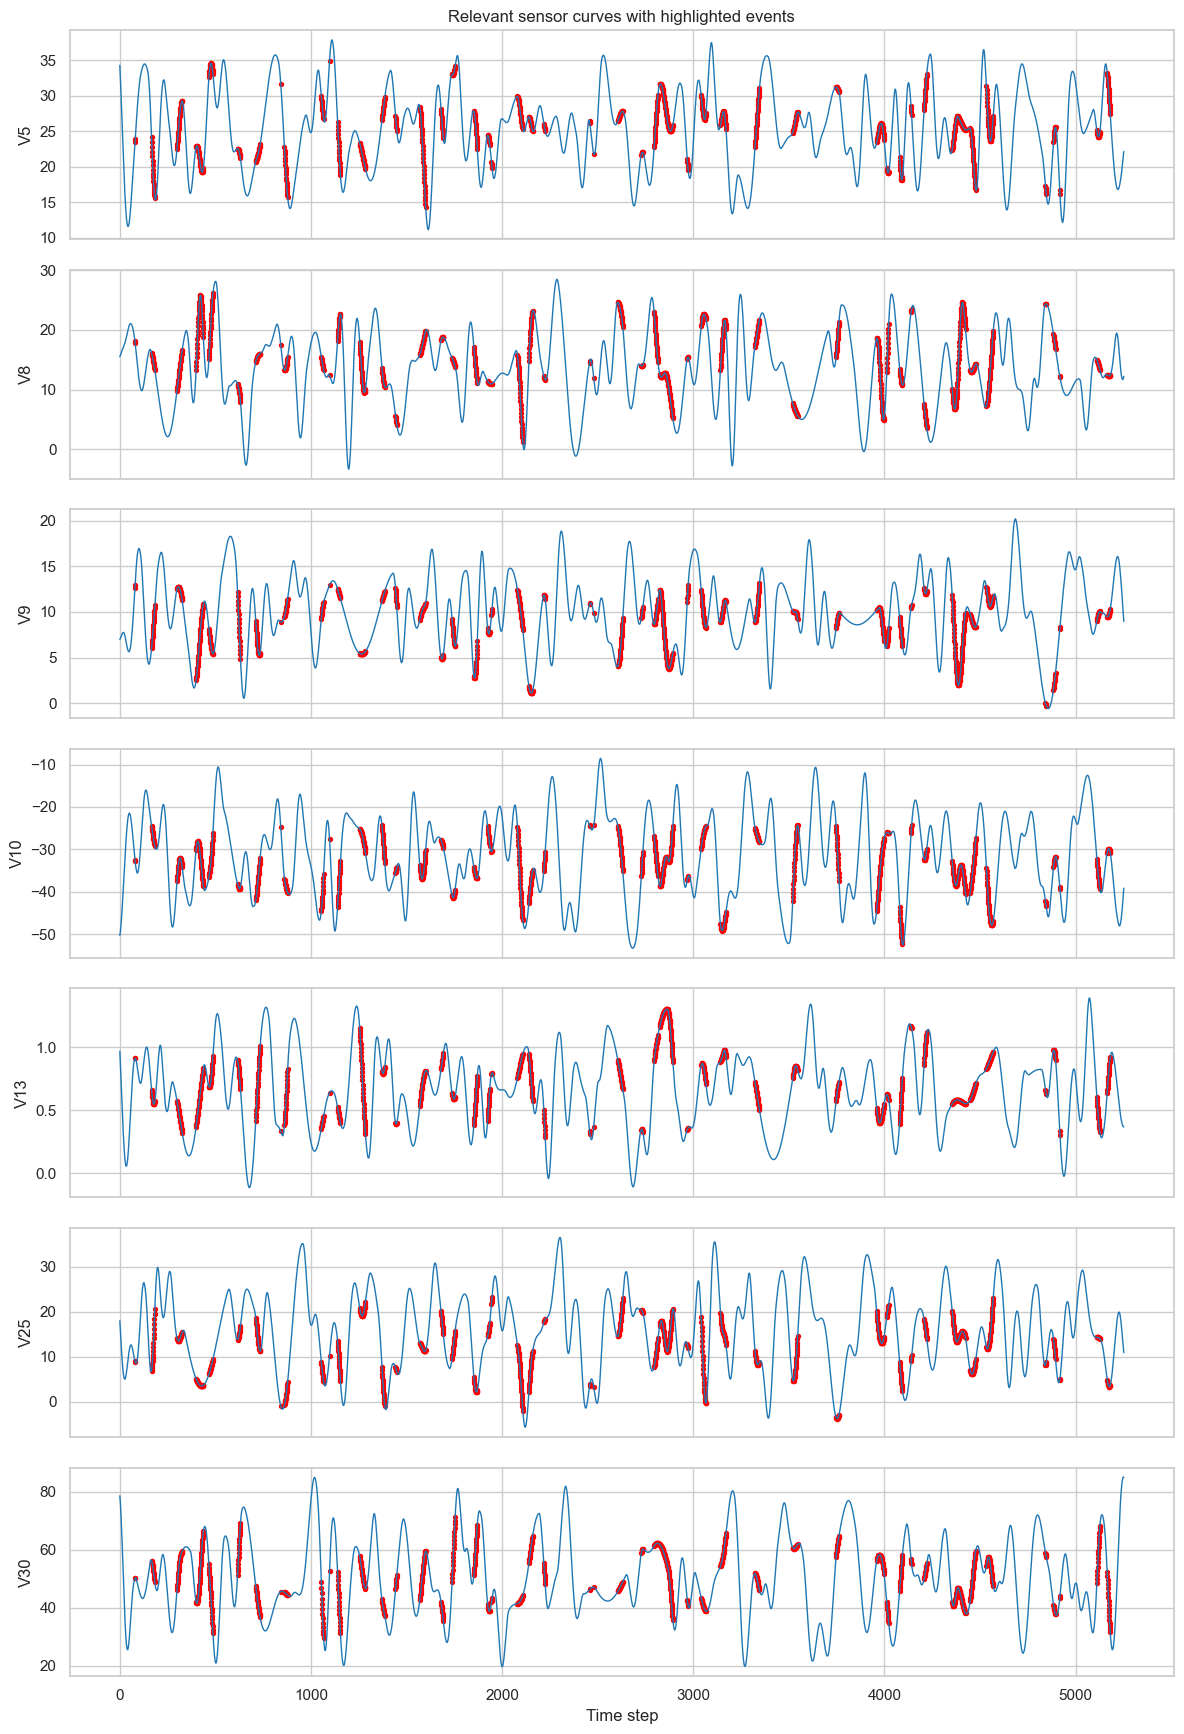

In [6]:
sig_sup = np.asarray(extra["SIG_SUPPOS"])
time_steps = np.asarray(extra["time_steps"], dtype=int)

fig, axes = plt.subplots(len(CASE1_RELEVANT), 1, figsize=(12, 2.5 * len(CASE1_RELEVANT)), sharex=True)
axes = np.atleast_1d(axes)
for ax, var_idx in zip(axes, CASE1_RELEVANT):
    series = sig_sup[var_idx - 1]
    ax.plot(series, color="tab:blue", linewidth=1)
    hits = time_steps[(time_steps >= 0) & (time_steps < series.size)]
    ax.scatter(hits, series[hits], color="red", s=8, label="event")
    ax.set_ylabel(f"V{var_idx}")
axes[0].set_title("Relevant sensor curves with highlighted events")
axes[-1].set_xlabel("Time step")
plt.tight_layout()

### Rectify the data

Rectification converts continuous readings into Â±1 indicators that capture whether
each feature lies within its learned bounds. This is the transformation described
in the paper and used before fitting the sparse logistic model.

In [7]:
groups = organize(dset_train)
rt_train, limits = rectify_fast(dset_train, groups, limits=None, sdfilter=None, snap=0.001)
rt_test, _ = rectify_fast(dset_test, groups, limits=limits, sdfilter=None, snap=0.001)

raw_feature_cols = [c for c in dset_train.columns if c not in EXCLUDE_COLS]
raw_train = dset_train[raw_feature_cols].copy()
raw_test = dset_test[raw_feature_cols].copy()

print(f"Rectified train shape: {rt_train.shape}, test shape: {rt_test.shape}")
print(f"Raw train shape: {raw_train.shape}, test shape: {raw_test.shape}")

rectified_preview = rt_train[[*TRUE_FEATURES, RESP_COL]].head()
display(rectified_preview)

Rectified train shape: (3669, 441), test shape: (1573, 441)
Raw train shape: (3669, 441), test shape: (1573, 441)


,V5TM10,V8TM10,V9TM1,V10TM0,V13TM2,V25TM3,V30TM7,INDC
0,1,1,-1,1,-1,-1,-1,False
1,1,1,1,-1,1,1,1,False
2,1,1,1,1,1,1,-1,False
3,-1,1,-1,1,1,1,1,False
4,1,1,-1,1,1,-1,1,False


### L1 logistic regression (with and without rectification)

The 1-SE selection rule keeps the models sparse and mirrors the R implementation.

In [8]:
logistic_outputs = {}

sk_rect_pipe, sk_rect_info = sklearn_fit_1se_rectified(
    rt_train,
    cv=3,
    cs=25,
    c_lo=-4,
    c_hi=4,
    tol=1e-3,
    max_iter=10000,
    solver="saga",
    random_state=42,
)

sk_raw_pipe, sk_raw_info = sklearn_fit_1se_raw(
    raw_train,
    cv=3,
    cs=25,
    c_lo=-4,
    c_hi=4,
    tol=1e-3,
    max_iter=10000,
    solver="saga",
    random_state=42,
)

prob_rect_tr, y_rect_tr, auc_rect_tr, f1_rect_tr = evaluate(sk_rect_pipe, rt_train)
prob_rect_te, y_rect_te, auc_rect_te, f1_rect_te = evaluate(sk_rect_pipe, rt_test)
add_metrics("L1 Logistic", "Rectified", auc_rect_tr, auc_rect_te, f1_rect_tr, f1_rect_te)
logistic_outputs["rectified"] = dict(train=(prob_rect_tr, y_rect_tr), test=(prob_rect_te, y_rect_te))

prob_raw_tr, y_raw_tr, auc_raw_tr, f1_raw_tr = evaluate(sk_raw_pipe, raw_train)
prob_raw_te, y_raw_te, auc_raw_te, f1_raw_te = evaluate(sk_raw_pipe, raw_test)
add_metrics("L1 Logistic", "Raw", auc_raw_tr, auc_raw_te, f1_raw_tr, f1_raw_te)
logistic_outputs["raw"] = dict(train=(prob_raw_tr, y_raw_tr), test=(prob_raw_te, y_raw_te))

logistic_metrics = pd.DataFrame(
    [
        {"View": "Rectified", "C (1-SE)": sk_rect_info["C_1se"], "Train AUC": auc_rect_tr, "Test AUC": auc_rect_te},
        {"View": "Raw", "C (1-SE)": sk_raw_info["C_1se"], "Train AUC": auc_raw_tr, "Test AUC": auc_raw_te},
    ]
)
display(logistic_metrics)

,View,C (1-SE),Train AUC,Test AUC
0,Rectified,2154.43469,1.000000,0.999256
1,Raw,1.00000,0.950262,0.944507


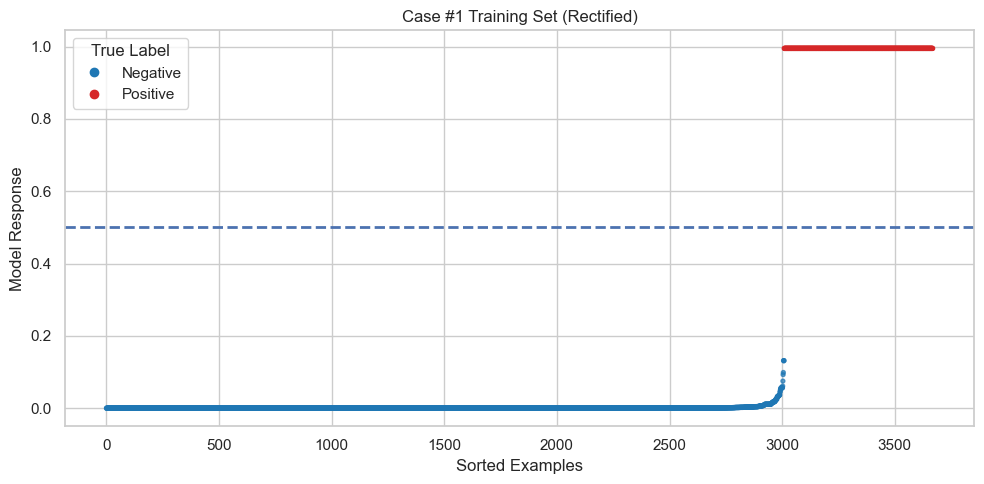

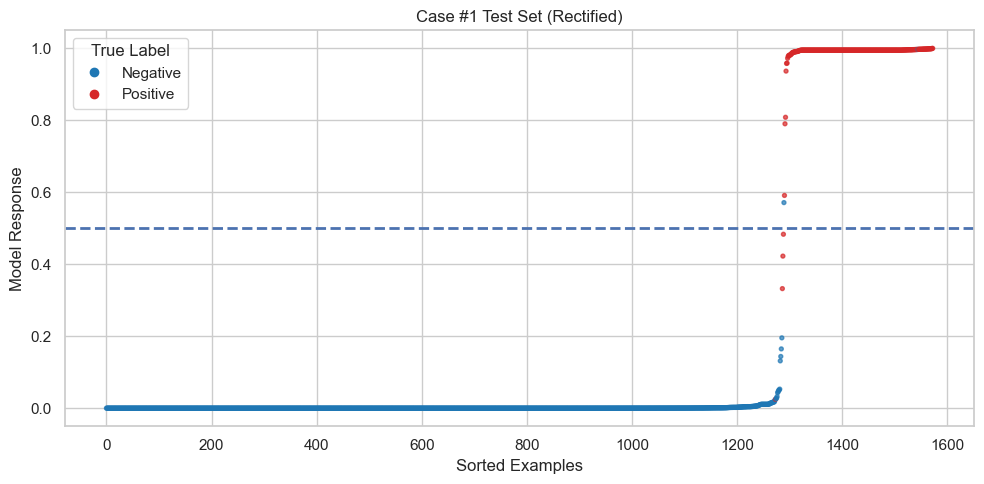

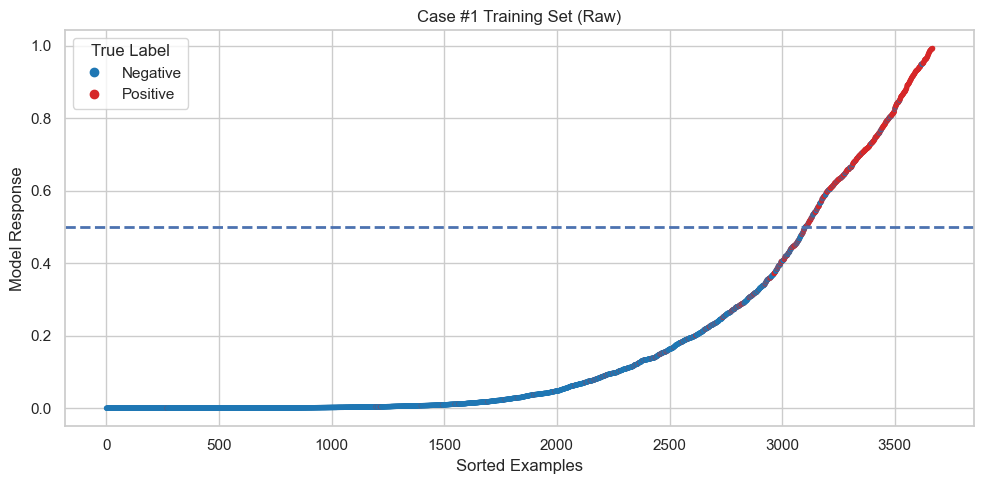

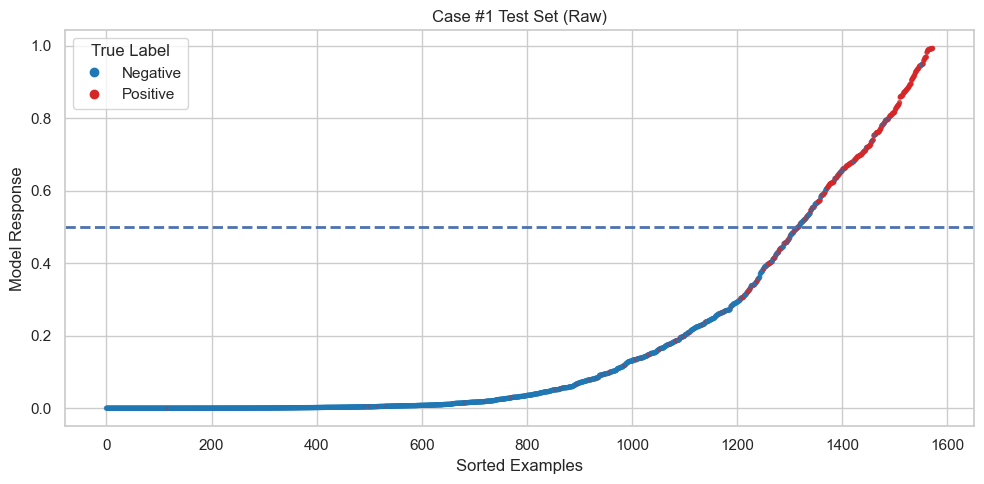

In [9]:
for view, label in [("rectified", "Rectified"), ("raw", "Raw")]:
    train_prob, train_y = logistic_outputs[view]["train"]
    test_prob, test_y = logistic_outputs[view]["test"]
    plot_sorted(train_prob, train_y, f"Case #1 Training Set ({label})")
    plot_sorted(test_prob, test_y, f"Case #1 Test Set ({label})")
plt.show()

### Inspect logistic coefficients

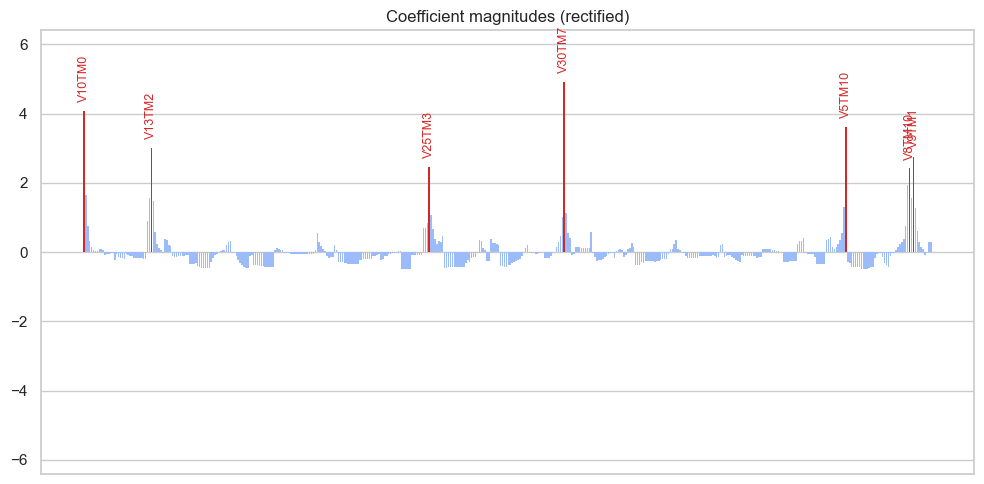

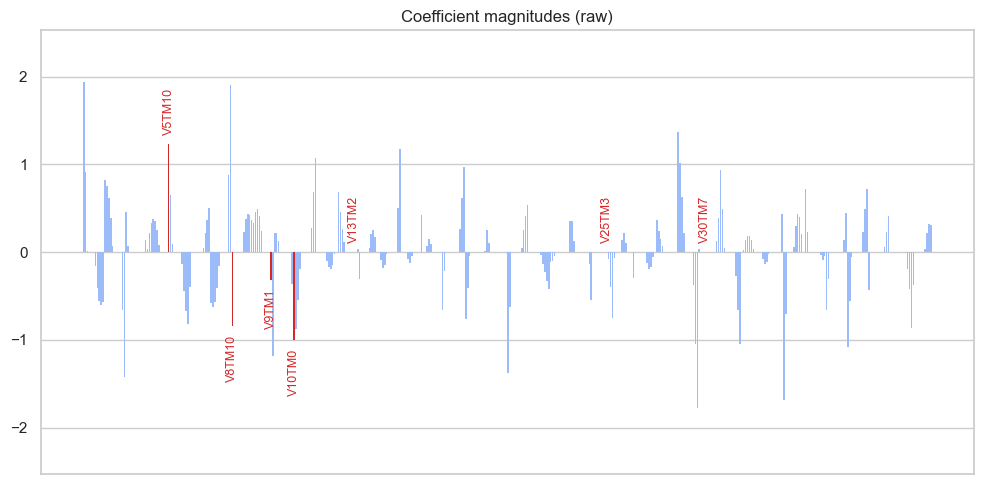

In [10]:
rect_features = rt_train.drop(columns=[RESP_COL]).columns.tolist()
coef_rect = coefficient_series_only(sk_rect_pipe, rect_features)
plot_coeff_bars(coef_rect, "Coefficient magnitudes (rectified)", highlights=TRUE_FEATURES)

raw_features = raw_train.drop(columns=[RESP_COL]).columns.tolist()
coef_raw = coefficient_series_only(sk_raw_pipe, raw_features)
plot_coeff_bars(coef_raw, "Coefficient magnitudes (raw)", highlights=TRUE_FEATURES)
plt.show()

### Random forest baselines

Tree ensembles overfit easily on the untransformed data. Running them on the rectified view
demonstrates how much the preprocessing step helps even non-linear models.

In [11]:
rf_params = dict(n_estimators=500, max_depth=None, n_jobs=-1, random_state=42, class_weight="balanced_subsample")
rf_raw = RandomForestClassifier(**rf_params)
rf_raw.fit(raw_train.drop(columns=[RESP_COL]), raw_train[RESP_COL].astype(int))
prob_rf_raw_tr, y_rf_raw_tr, auc_rf_raw_tr, f1_rf_raw_tr = evaluate(rf_raw, raw_train)
prob_rf_raw_te, y_rf_raw_te, auc_rf_raw_te, f1_rf_raw_te = evaluate(rf_raw, raw_test)
add_metrics("Random Forest", "Raw", auc_rf_raw_tr, auc_rf_raw_te, f1_rf_raw_tr, f1_rf_raw_te)

rf_rect = RandomForestClassifier(**rf_params)
rf_rect.fit(rt_train.drop(columns=[RESP_COL]), rt_train[RESP_COL].astype(int))
prob_rf_rect_tr, y_rf_rect_tr, auc_rf_rect_tr, f1_rf_rect_tr = evaluate(rf_rect, rt_train)
prob_rf_rect_te, y_rf_rect_te, auc_rf_rect_te, f1_rf_rect_te = evaluate(rf_rect, rt_test)
add_metrics("Random Forest", "Rectified", auc_rf_rect_tr, auc_rf_rect_te, f1_rf_rect_tr, f1_rf_rect_te)

rf_metrics = pd.DataFrame(
    [
        {"View": "Raw", "Train AUC": auc_rf_raw_tr, "Test AUC": auc_rf_raw_te},
        {"View": "Rectified", "Train AUC": auc_rf_rect_tr, "Test AUC": auc_rf_rect_te},
    ]
)
display(rf_metrics)

rf_outputs = {
    "raw": dict(train=(prob_rf_raw_tr, y_rf_raw_tr), test=(prob_rf_raw_te, y_rf_raw_te)),
    "rectified": dict(train=(prob_rf_rect_tr, y_rf_rect_tr), test=(prob_rf_rect_te, y_rf_rect_te)),
}

c:\Users\jason\.conda\envs\cutlass\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\jason\.conda\envs\cutlass\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\jason\.conda\envs\cutlass\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\jason\.conda\envs\cutlass\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


,View,Train AUC,Test AUC
0,Raw,1.0,0.999645
1,Rectified,1.0,0.999961


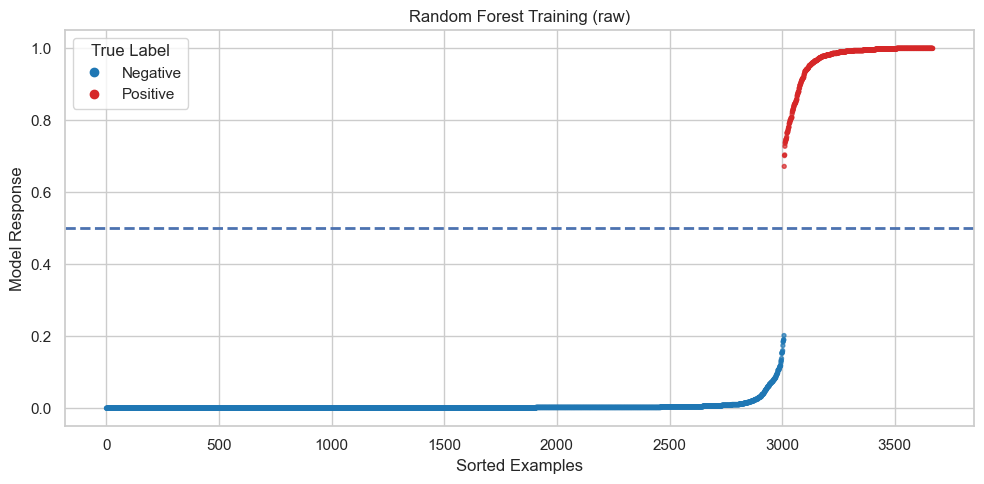

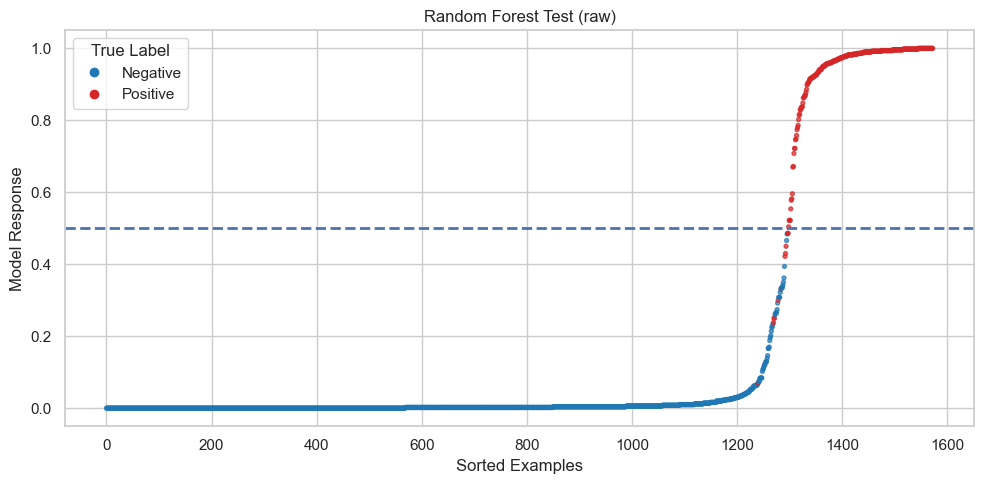

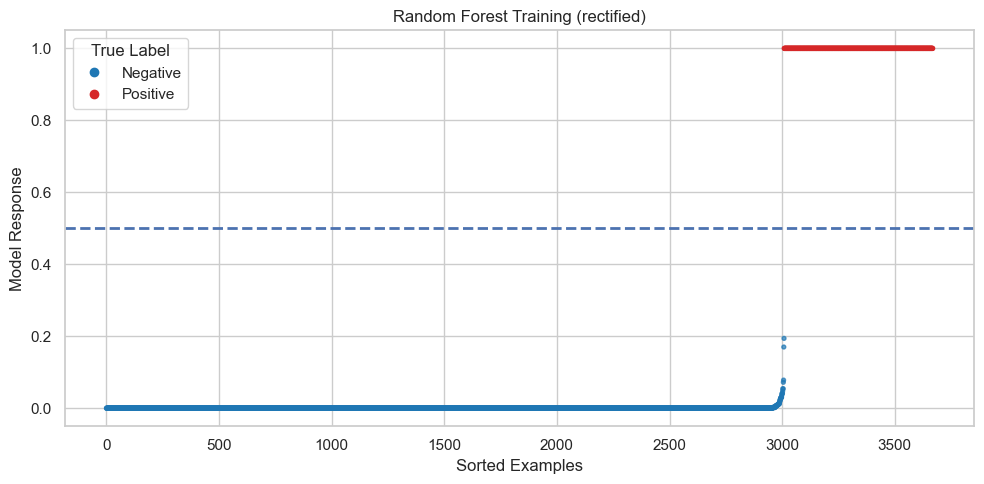

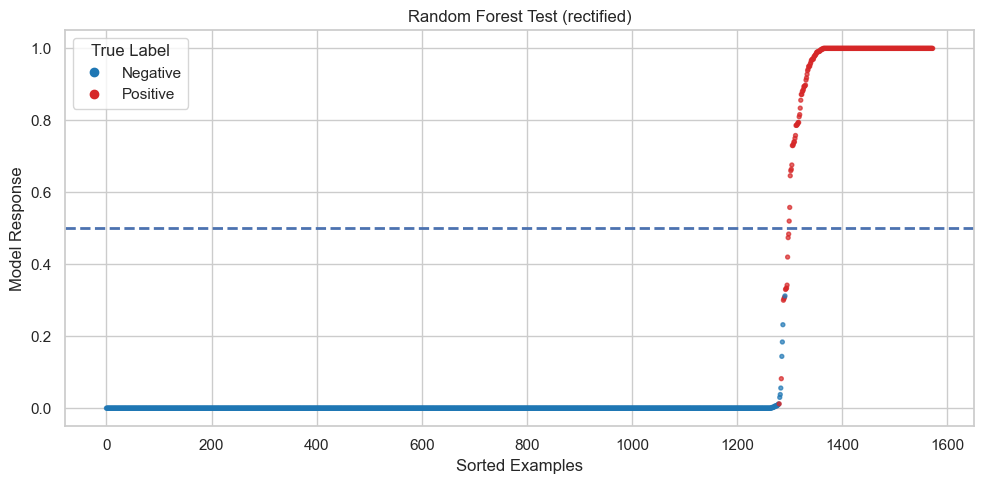

In [12]:
for view in ["raw", "rectified"]:
    train_prob, train_y = rf_outputs[view]["train"]
    test_prob, test_y = rf_outputs[view]["test"]
    plot_sorted(train_prob, train_y, f"Random Forest Training ({view})")
    plot_sorted(test_prob, test_y, f"Random Forest Test ({view})")
plt.show()

### Group LASSO style fit

`groupyr.LogisticSGLCV` enforces grouped sparsity so each variable's time lags are
either kept or dropped together, similar to the group lasso experiments in the R notebook.

Best alpha selected: 0.0001


,Train AUC,Test AUC
0,0.951904,0.945664


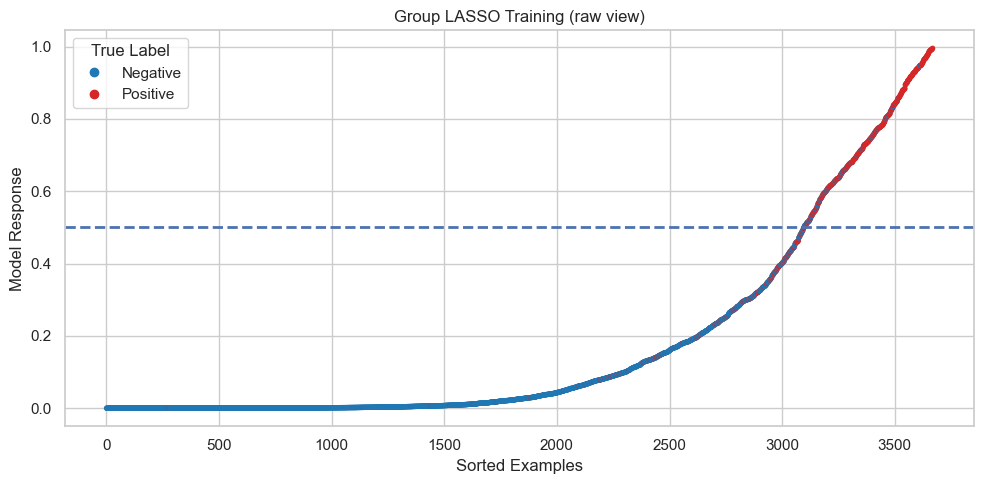

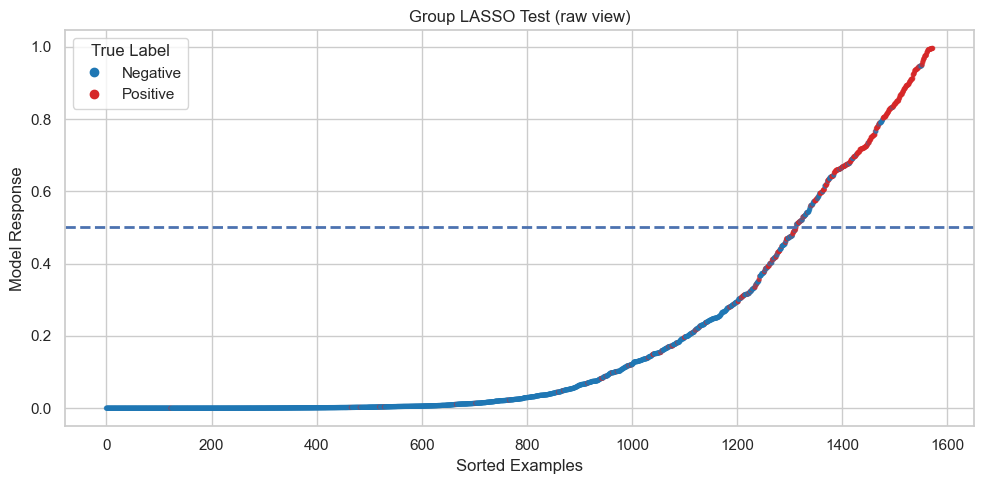

In [13]:
group_feature_cols = raw_train.drop(columns=[RESP_COL]).columns.tolist()
group_labels = [col.split("TM")[0] for col in group_feature_cols]
group_to_indices = {}
for idx, label in enumerate(group_labels):
    group_to_indices.setdefault(label, []).append(idx)
group_ids = [np.asarray(idxs, dtype=int) for label, idxs in sorted(group_to_indices.items())]

scaler = StandardScaler(with_mean=True, with_std=True)
Xtr = scaler.fit_transform(raw_train[group_feature_cols])
Xte = scaler.transform(raw_test[group_feature_cols])
ytr = raw_train[RESP_COL].astype(int).to_numpy()
yte = raw_test[RESP_COL].astype(int).to_numpy()

sgl = LogisticSGLCV(
    groups=group_ids,
    l1_ratio=0.5,
    n_alphas=40,
    max_iter=4000,
    tol=1e-4,
    cv=3,
    verbose=False,
    n_jobs=-1,
    random_state=42,
)
sgl.fit(Xtr, ytr)
prob_sgl_tr = sgl.predict_proba(Xtr)[:, 1]
prob_sgl_te = sgl.predict_proba(Xte)[:, 1]
prec_tr, rec_tr, _ = precision_recall_curve(ytr, prob_sgl_tr)
f1_sgl_tr = 2 * rec_tr * prec_tr / (rec_tr + prec_tr + 1e-9)
prec_te, rec_te, _ = precision_recall_curve(yte, prob_sgl_te)
f1_sgl_te = 2 * rec_te * prec_te / (rec_te + prec_te + 1e-9)
auc_sgl_tr = roc_auc_score(ytr, prob_sgl_tr)
auc_sgl_te = roc_auc_score(yte, prob_sgl_te)
add_metrics(
    "Logistic Group LASSO",
    "Raw",
    auc_sgl_tr,
    auc_sgl_te,
    f1_sgl_tr,
    f1_sgl_te,
    notes="Group-wise penalty via groupyr.LogisticSGLCV",
)

print(f"Best alpha selected: {sgl.alpha_:.4f}")
display(pd.DataFrame([{"Train AUC": auc_sgl_tr, "Test AUC": auc_sgl_te}]))
plot_sorted(prob_sgl_tr, ytr.astype(bool), "Group LASSO Training (raw view)")
plot_sorted(prob_sgl_te, yte.astype(bool), "Group LASSO Test (raw view)")
plt.show()

### Overall metrics

In [ ]:
metrics_df = pd.DataFrame(metrics_records) 
display(metrics_df.sort_values("Test AUC", ascending=False).reset_index(drop=True))

,Model,View,Train AUC,Test AUC,Train max F1,Test max F1,Notes
0,Random Forest,Rectified,1.000000,0.999961,1.000000,0.994746,
1,Random Forest,Raw,1.000000,0.999645,1.000000,0.985915,
2,L1 Logistic,Rectified,1.000000,0.999256,1.000000,0.994764,
3,Logistic Group LASSO,Raw,0.951904,0.945664,0.776957,0.771005,Group-wise penalty via groupyr.LogisticSGLCV
4,L1 Logistic,Raw,0.950262,0.944507,0.772161,0.768719,
